# Udacity Self Driving Car Nano Degree
### Project 2 - Advanced Lane Finding

### Pipeline Overview
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
%matplotlib inline

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Load list of calibration files

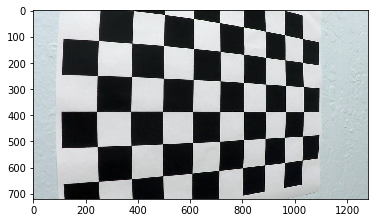

In [2]:
cal_images = glob.glob('camera_cal/cal*.jpg')
test = cal_images[0]
img1 = cv2.imread(test)
img_size = (img1.shape[1], img1.shape[0])
plt.imshow(img1)

Prepare grid of object points and empty arrays for storing object and image points

In [3]:
npy = 9
npx = 6
objp = np.zeros((npx*npy,3), np.float32)
objp[:,:2] = np.mgrid[0:npy, 0:npx].T.reshape(-1,2)
objpts = []
imgpts = []

Find corners on chessboard pattern

In [4]:
for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (npy, npx), None)
    
    if ret:
        objpts.append(objp)
        imgpts.append(corners)

Calculate distortion coefficients and calibration matrix. Verify undistort works.

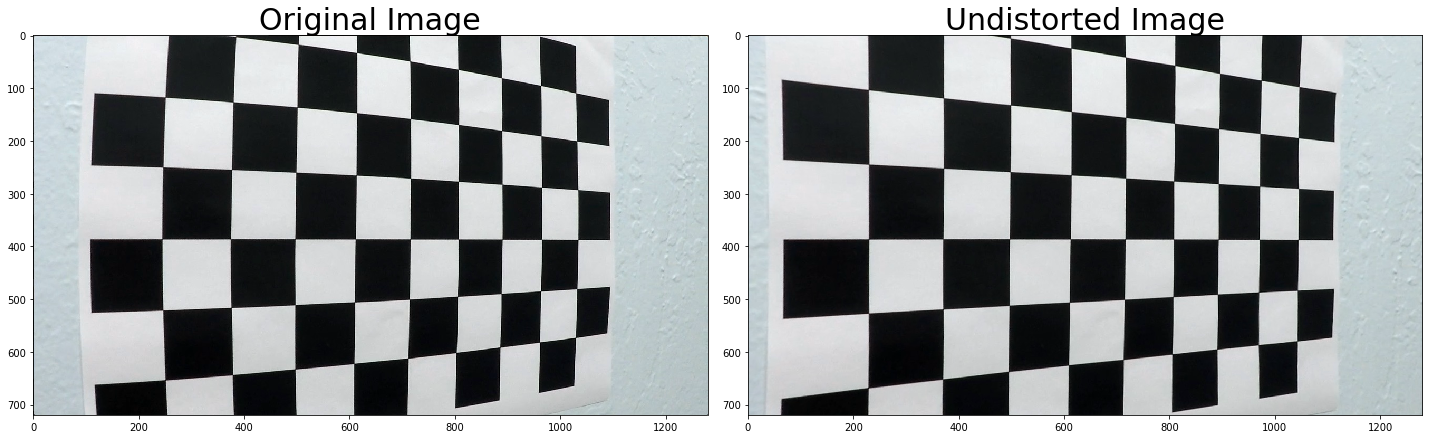

In [5]:
# these values will be use throughout code
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)

def undistort_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

dst = undistort_image(img1)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize = 30)
#mpimg.imsave("output_images/undistorted.png", dst)
fig.tight_layout()
plt.savefig("output_images/undistorted.png")

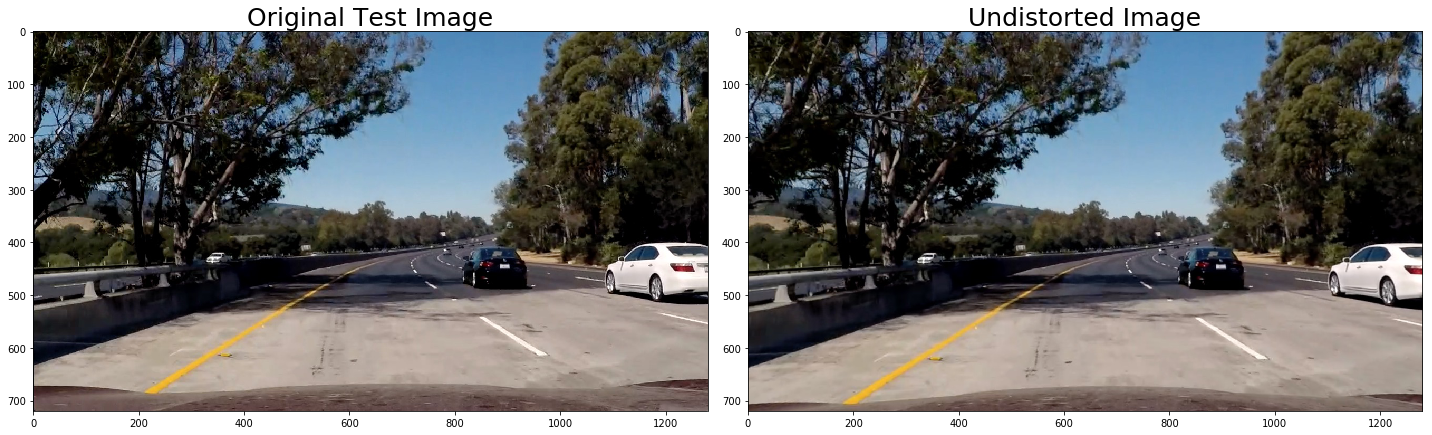

In [6]:
test_image = mpimg.imread('./test_images/test5.jpg')
undst = undistort_image(test_image)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))
ax1.imshow(test_image)
ax1.set_title('Original Test Image', fontsize = 25)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize = 25)
fig.tight_layout()
plt.savefig("output_images/undistorted_test.png")

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.


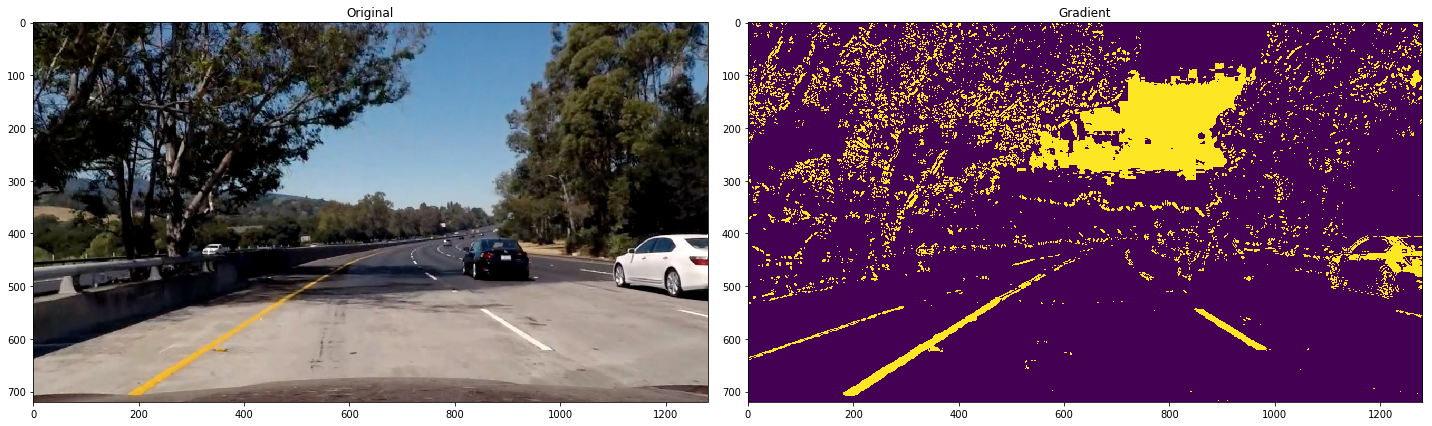

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    scaled = np.int8(255 * abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    scaled = np.int8(255 * abs_sobel / np.max(abs_sobel))
     # Apply threshold
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Apply threshold
    dir_binary = np.zeros_like(dir)
    dir_binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return dir_binary

def grad_thresholding(image, ksize=5, grad_thresholds=(20,100), mag_thresholds=(100,200), dir_thresholds=(0.7, 1.3)):
    # image is assumed to be one channel
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=grad_thresholds)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=grad_thresholds)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=mag_thresholds)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresholds)   
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

def color_grad(image, ksize = 5, s_thresh = (170, 255), sx_thresh = (20,100), color = False):
    img = np.copy(image)
    
    # convert to HLS
    r_channel = img[:,:,0]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # apply sobel
#     sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
#     abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    
#     # thrshold x
#     sxbinary = np.zeros_like(scaled_sobel)
#     sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    l_s_image = np.dstack((l_channel, l_channel, l_channel))
    sxbinary = grad_thresholding(l_s_image, ksize = ksize, grad_thresholds=sx_thresh)
    
    # threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= s_thresh[0]) & (r_channel <= s_thresh[1])] = 1
    col_binary = np.zeros_like(s_binary)
    col_binary[((s_binary == 1) & (r_binary == 1))] = 1    
    
    # stacked each channel
    if color == True:
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, col_binary)) * 255
        return color_binary
    else:
        binary = np.zeros_like(s_channel)
        binary[((sxbinary == 1) | (col_binary == 1))] = 1       
        return binary * 255

grad_image = mpimg.imread('./test_images/test5.jpg')
grad_image = mpimg.imread('../advanced_vision/color-shadow-example.jpg')
grad_image = undistort_image(grad_image)
grad_grad = color_grad(grad_image, ksize = 11, s_thresh = (100, 255), sx_thresh = (20,120), color = False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(grad_image)
ax1.set_title('Original')
ax2.imshow(grad_grad)
ax2.set_title('Gradient')
fig.tight_layout()
plt.savefig("output_images/thresholded_binary.png")

## 3. Apply perspective transform to get bird's eye view

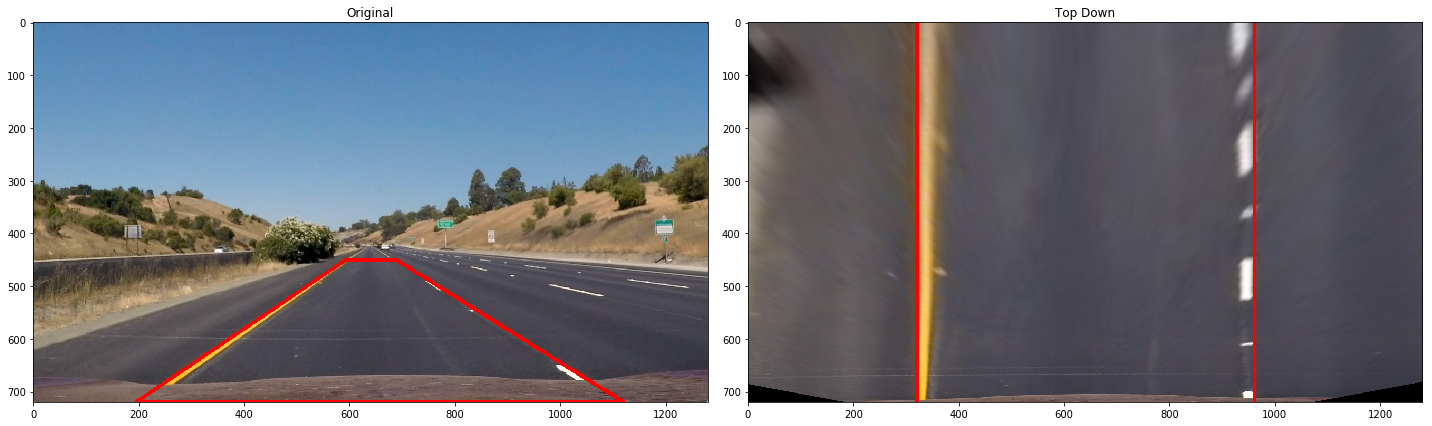

In [8]:
def get_persp_transf(image, npx, npy, color_in = False):
    if color_in == True:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        im_size = gray.shape[::-1]
    else:
        gray = image
        im_size = gray.shape
    #print(im_size)
    # define source point locations
    # locations: top left, top right, bottom left, bottom right
    src = np.float32([[593,450], [688,450], [195,720], [1120,720]])    
    # define destination point locations
    dst = np.float32([[320,0],[im_size[0]-320,0],[320,im_size[1]],[im_size[0]-320,im_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    inv_M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, im_size, flags = cv2.INTER_LINEAR)
    cv2.line(warped, (320,0), (320,im_size[1]), (255,0,0), thickness = 5)
    cv2.line(warped, (im_size[0]-320,0), (im_size[0]-320,im_size[1]), (255,0,0), thickness = 5)  
    
    return warped, M, inv_M

persp_image = mpimg.imread('./test_images/straight_lines1.jpg')
undist = undistort_image(persp_image)
top_down, perspective_M, inv_M = get_persp_transf(undist, npx, npy, color_in = True)  
src = np.int32([[(688,450), (593,450), (195,720), (1120,720)]])
cv2.polylines(persp_image, src, True, (255,0,0), thickness = 5)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
ax1.imshow(persp_image)
ax1.set_title('Original')
ax2.imshow(top_down)
ax2.set_title('Top Down')
fig.tight_layout()
plt.savefig("output_images/transformed_road.png")

Apply same transform to new image 

Text(0.5, 1.0, 'Top Down')

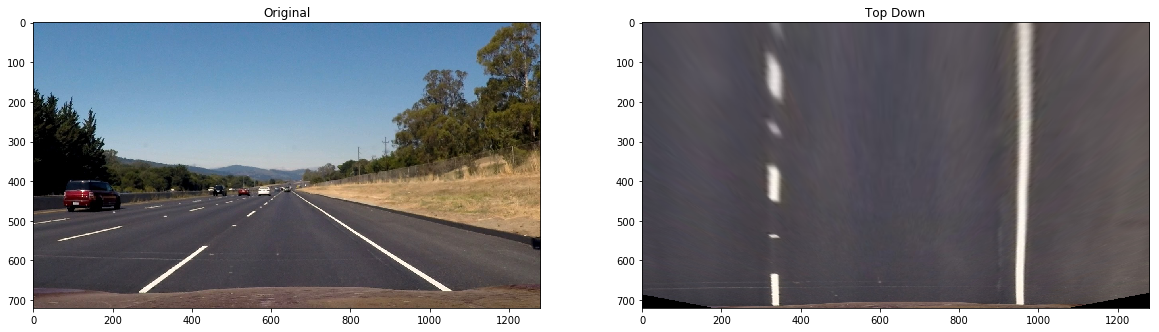

In [9]:
persp_image = mpimg.imread('./test_images/straight_lines2.jpg')
undist = undistort_image(persp_image)
top_down = cv2.warpPerspective(undist, perspective_M, undist[:,:,-1].T.shape, flags = cv2.INTER_LINEAR) 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
ax1.imshow(persp_image)
ax1.set_title('Original')
ax2.imshow(top_down)
ax2.set_title('Top Down')


Apply whole process to get binary image -- i.e. pipeline so far...

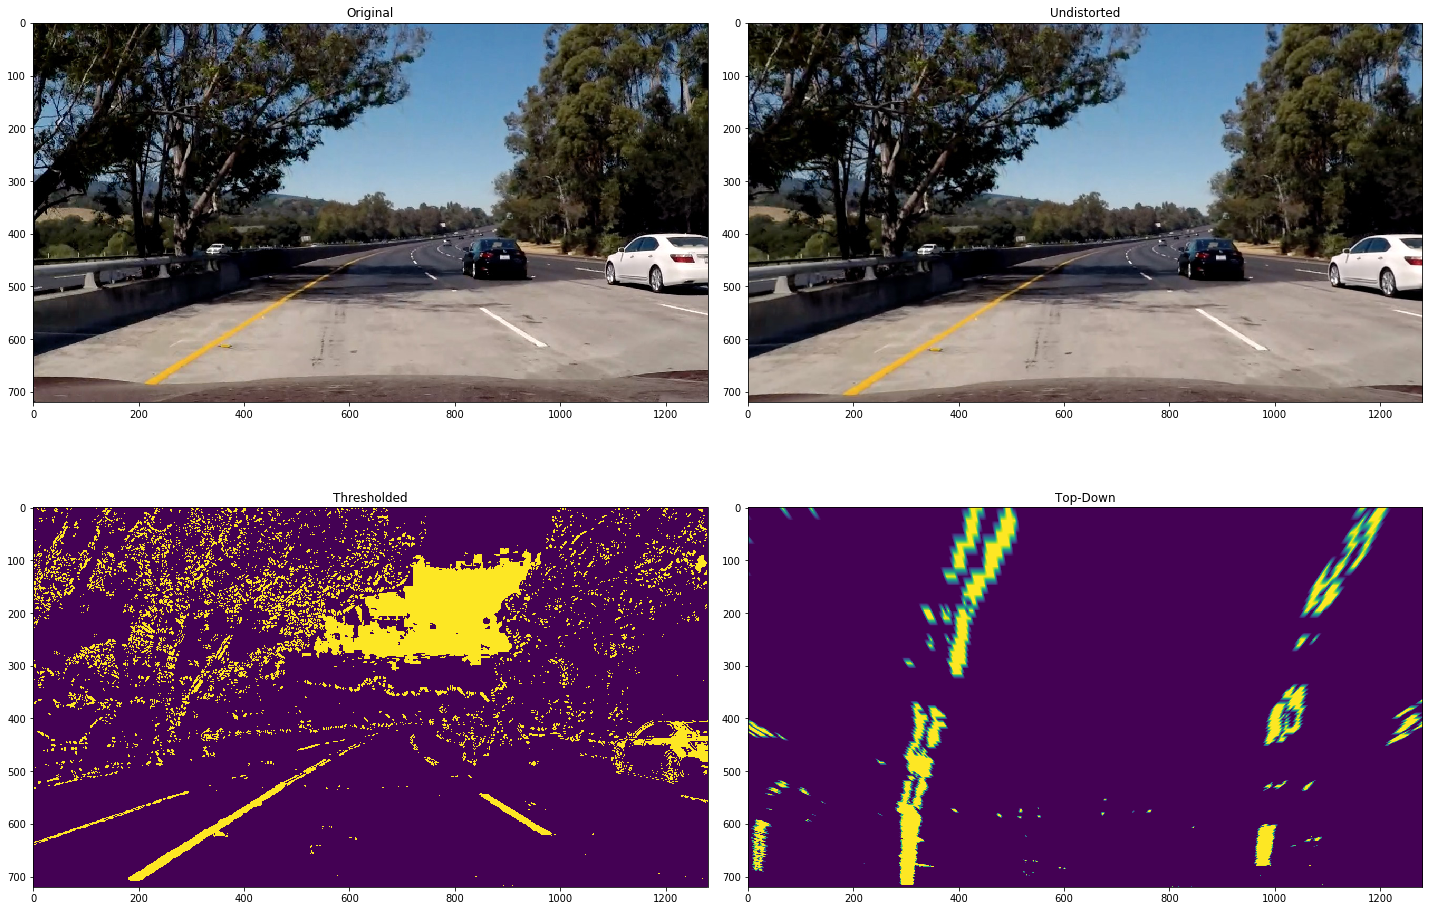

In [10]:
persp_image = mpimg.imread('./test_images/test5.jpg')
#persp_image = cv2.GaussianBlur(persp_image, ksize=(11,11), sigmaX=5)
persp_image_ud = undistort_image(persp_image)
#print(persp_image.shape)
grad_binary = color_grad(persp_image_ud, ksize = 11, s_thresh = (100, 255), sx_thresh = (20,120), color = False)
top_down = cv2.warpPerspective(grad_binary, perspective_M, grad_binary.T.shape, flags = cv2.INTER_LINEAR) 
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(20,14))
ax1.imshow(persp_image)
ax1.set_title('Original')
ax2.imshow(persp_image_ud)
ax2.set_title('Undistorted')
ax3.imshow(grad_binary)
ax3.set_title('Thresholded')
ax4.imshow(top_down)
ax4.set_title('Top-Down')
fig.tight_layout()
plt.savefig("output_images/warped_binary.png")

## 4. Detect lane pixels and fit to find the lane boundary.

### use histogram method to get inital polyfit


In [11]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
#             & (nonzerox >= win_xleft_low) & (nonzerox <win_xleft_high)).nonzero()[0]
#         good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
#             & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        if win_xleft_low > 0 and win_xleft_high < binary_warped.shape[1]:
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
                 & (nonzerox >= win_xleft_low) & (nonzerox <win_xleft_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if win_xright_low > 0 and win_xright_high < binary_warped.shape[1]:
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
                 & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            right_lane_inds.append(good_right_inds)
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial_hist(binary_warped):

    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

left_fit_0, right_fit_0 = fit_polynomial_hist(top_down)

Use previously calculated polynomial fits to search region of interest

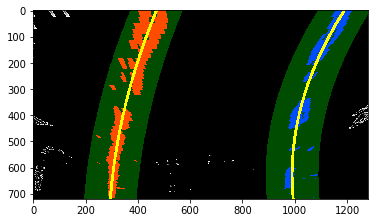

In [12]:
#left_fit_0 = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit_0 = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

left_fit_0, right_fit_0 = fit_polynomial_hist(top_down)
#print(left_fit_0)
#print(right_fit_0)

def fit_poly_from_data(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit_0, right_fit_0):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values ###
    # within the +/- margin of our polynomial function ###
    left_lane_fit = left_fit_0[0]*nonzeroy**2 + left_fit_0[1]*nonzeroy + left_fit_0[2]
    right_lane_fit = right_fit_0[0]*nonzeroy**2 + right_fit_0[1]*nonzeroy + right_fit_0[2]
    left_lane_inds = ((nonzerox >= left_lane_fit - margin) \
                    & (nonzerox < left_lane_fit + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_lane_fit - margin) \
                    & (nonzerox < right_lane_fit + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = \
                fit_poly_from_data(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    left_fit_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))], dtype=int)
    right_fit_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))], dtype=int)


    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    cv2.polylines(result, [left_fit_pts], isClosed=False, color=(255,255,0), thickness = 10)
    cv2.polylines(result, [right_fit_pts], isClosed=False, color=(255,255,0), thickness = 10)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit, right_fit

lane_window, left_fit, right_fit = search_around_poly(top_down, left_fit_0, right_fit_0)
# View your output
plt.imshow(lane_window)
plt.savefig("output_images/lane_pixels.png")

## 5. Determine the curvature of the lane and vehicle position with respect to center.

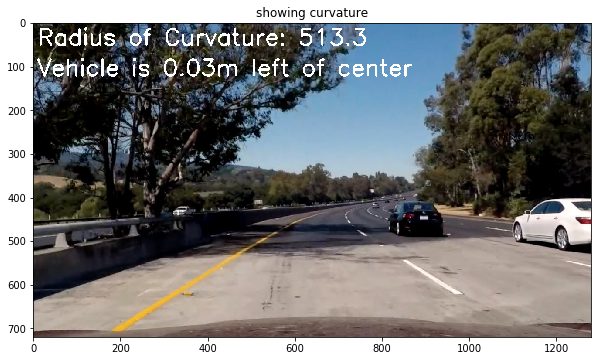

In [13]:
def show_curvature(image, left_fit, right_fit):
    
    img_out = np.copy(image)

    ym_per_pix = 30./720
    xm_per_pix = 3.7/700
    
    yvalue = img_out.shape[0] * ym_per_pix
    
    # for scaled parabola: x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    a_l = left_fit[0] * xm_per_pix / (ym_per_pix)**2
    b_l = left_fit[1] * xm_per_pix / ym_per_pix
    c_l = left_fit[2] * xm_per_pix
    a_r = right_fit[0] * xm_per_pix / (ym_per_pix)**2
    b_r = right_fit[1] * xm_per_pix / ym_per_pix
    c_r = right_fit[2] * xm_per_pix
    
    left_curverad = (1+(2*a_l*yvalue+b_l)**2)**(3.0/2)/np.abs(2*a_l)
    right_curverad = (1+(2*a_r*yvalue+b_r)**2)**(3.0/2)/np.abs(2*a_r)
    
    left_lane_pt = a_l * yvalue ** 2 + b_l * yvalue + c_l
    right_lane_pt = a_r * yvalue ** 2 + b_r * yvalue + c_r
    cntr = np.mean([left_lane_pt, right_lane_pt])
    offset = img_out.shape[1]/2.0 * xm_per_pix - cntr
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    topLeftCornerOfText    = (10,50)
    topLeftCornerOfText2   = (10,120)    
    fontScale              = 1.75
    fontColor              = (255,255,255)
    lineType               = 3

    curvature = np.mean([left_curverad, right_curverad])
    text1 = str('Radius of Curvature: %.1f' % curvature)
    left_right = 'right'
    if offset < 0:
        left_right = 'left'
    text2 = str('Vehicle is %.2fm %s of center' % (np.abs(offset), left_right))

    cv2.putText(img_out, text1 , topLeftCornerOfText, font, fontScale, fontColor, lineType)
    cv2.putText(img_out, text2 , topLeftCornerOfText2, font, fontScale, fontColor, lineType)

    return img_out, curvature

curv_annotated, _ = show_curvature(persp_image_ud, left_fit, right_fit)

fig = plt.figure(figsize=(10,6))
plt.imshow(curv_annotated)
plt.title('showing curvature')
plt.savefig("output_images/curvature.png")

## 6. Warp the detected lane boundaries back onto the original image.

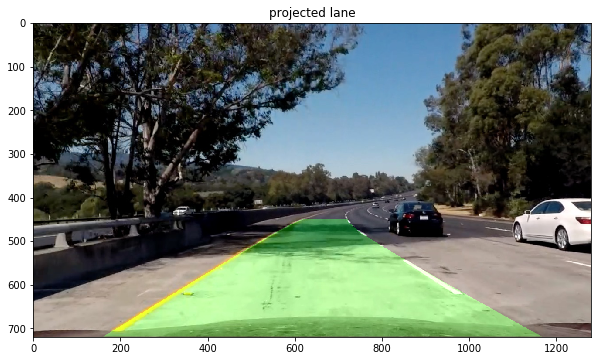

In [14]:
def project_lane_lines(image, poly_fit_l, poly_fit_r):
    img = image.copy()
    img_shape = img.shape
    lanes = np.zeros_like(image)
    
    plot_y = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    plot_x_left = np.polyval(poly_fit_l, plot_y)   
    plot_points_left = (np.asarray([plot_x_left, plot_y]).T).astype(np.int32)   
    plot_x_right = np.polyval(poly_fit_r, plot_y)   
    plot_points_right = (np.asarray([plot_x_right, plot_y]).T).astype(np.int32) 
    plot_points = np.vstack([plot_points_left, plot_points_right[::-1]])
    
    cv2.fillPoly(lanes, np.int32([plot_points]), (0, 255, 0))

    lanes = cv2.warpPerspective(lanes, inv_M, img[:,:,-1].T.shape, flags = cv2.INTER_LINEAR) 
    
    projected = cv2.addWeighted(img, 1., lanes, .3, 0)
    
    return projected

projected = project_lane_lines(persp_image_ud, left_fit, right_fit)
fig = plt.figure(figsize=(10,6))
plt.imshow(projected)
plt.title('projected lane')
plt.savefig("output_images/projected_lane.png")


# Processing Pipeline:
## 1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

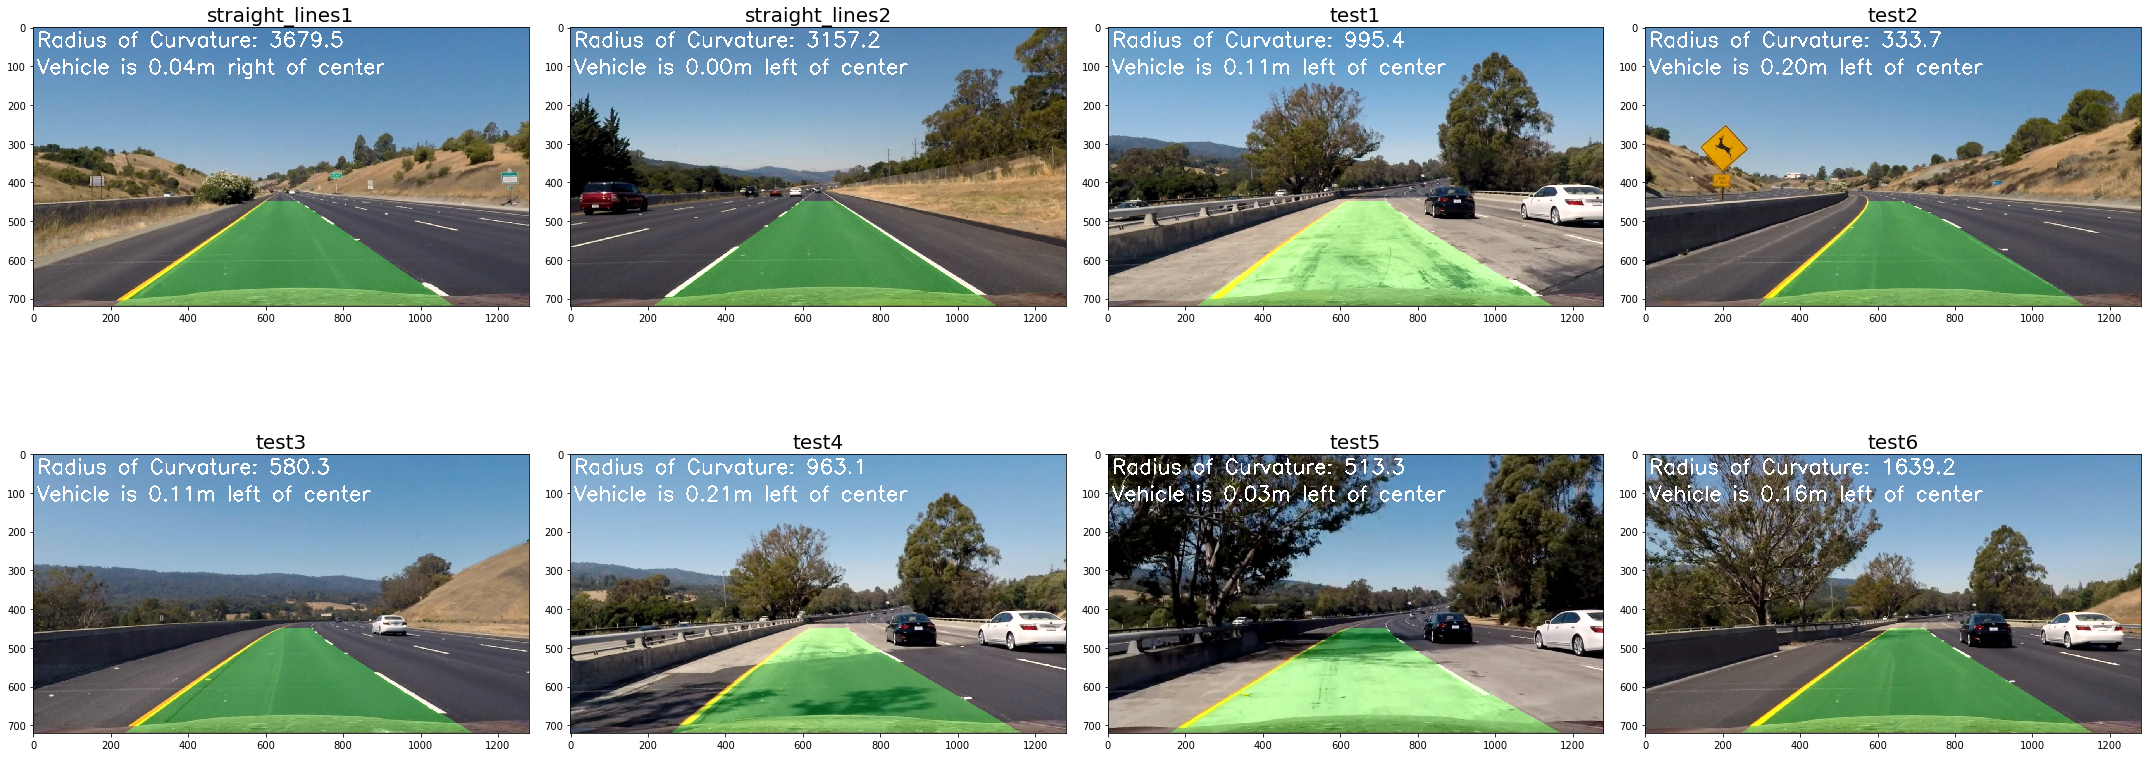

In [15]:
def pipeline(image, left_fit_0, right_fit_0):
    img = np.copy(image)
    img_und = undistort_image(img)
    #print('img_und',img_und.shape)
    grad_binary = color_grad(img_und, ksize = 11, s_thresh = (100, 255), sx_thresh = (20,120), color = False)
    #print('grad_binary',grad_binary.shape)
    top_down = cv2.warpPerspective(grad_binary, perspective_M, grad_binary.T.shape, flags = cv2.INTER_LINEAR)   
    #print('top_down',top_down.shape)
    try:
        _, left_fit, right_fit = search_around_poly(top_down, left_fit_0, right_fit_0)
    except:
        left_fit_0, right_fit_0 = fit_polynomial_hist(top_down) 
        _, left_fit, right_fit = search_around_poly(top_down, left_fit_0, right_fit_0)
    projected = project_lane_lines(img_und, left_fit, right_fit)
    #print('projected',projected.shape)
    final_out, curvature = show_curvature(projected, left_fit, right_fit)
    if np.absolute(curvature) < 400:
        try:
            left_fit_0, right_fit_0 = fit_polynomial_hist(top_down) 
        except:
            pass
    return final_out, left_fit_0, right_fit_0
    

test_images_files = sorted(glob.glob('./test_images/*.jpg'))
test_images = []
if len(test_images_files) > 0:
    for idx, fname in enumerate(test_images_files):
        #print(fname)
        img = mpimg.imread(fname)
        img_p, _, _ = pipeline(img, None, None)
        test_images.append(img_p)
else:
    print('No images read')
    
fig, axes = plt.subplots(2,4, figsize=(30,12))
fig.tight_layout()
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        text = test_images_files[i*(axes.shape[1]) + j]
        #print(text.split('/')[-1].split('.')[0])
        axes[i][j].imshow(test_images[i*(axes.shape[1]) + j])
        axes[i][j].set_title(text.split('/')[-1].split('.')[0],fontsize = 20)

plt.savefig("output_images/examples_out.png")

# Application to video
## * the pipeline is now applied to a video stream


In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_fit_0 = None
right_fit_0 = None

def process_image(image):
    global left_fit_0
    global right_fit_0
    result, left_fit_0, right_fit_0 = pipeline(image, left_fit_0, right_fit_0)
   
    return result

In [17]:
vid_output = './video_output.mp4'
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
vid_clip = clip1.fl_image(process_image) 
%time vid_clip.write_videofile(vid_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:41, 12.46it/s, now=None]

Moviepy - Building video ./video_output.mp4.
Moviepy - Writing video ./video_output.mp4



Moviepy - Done !
Moviepy - video ready ./video_output.mp4
CPU times: user 3min 28s, sys: 35 s, total: 4min 3s
Wall time: 3min 16s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [19]:
vid_output_c = './challenge_output.mp4'
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
vid_clip = clip1.fl_image(process_image) 
%time vid_clip.write_videofile(vid_output_c, audio=False)

t:   0%|          | 2/485 [00:00<00:39, 12.12it/s, now=None]

Moviepy - Building video ./challenge_output.mp4.
Moviepy - Writing video ./challenge_output.mp4



Moviepy - Done !
Moviepy - video ready ./challenge_output.mp4
CPU times: user 1min 19s, sys: 13.5 s, total: 1min 32s
Wall time: 1min 14s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output_c))

In [21]:
vid_output_c2 = './harder_challenge_output.mp4'
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
vid_clip = clip1.fl_image(process_image) 
%time vid_clip.write_videofile(vid_output_c2, audio=False)

t:   0%|          | 2/1199 [00:00<01:47, 11.09it/s, now=None]

Moviepy - Building video ./harder_challenge_output.mp4.
Moviepy - Writing video ./harder_challenge_output.mp4



Moviepy - Done !
Moviepy - video ready ./harder_challenge_output.mp4
CPU times: user 3min 35s, sys: 34 s, total: 4min 9s
Wall time: 3min 26s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output_c2))